In [1]:
import networkx as nx
import numpy as np
from walkers import Simulation

In [2]:
def sample_ER(N, p):
    rd = np.random.rand(N,N)
    A = np.triu(rd < (p))
    np.fill_diagonal(A, 0)
    return A
    
def gen_com_graph(N, n_coms, p_high, p_low):
    N_pc = int(N / n_coms)
    A_struct = np.zeros((N,N))
    for i in range(n_coms):
        A_struct[i*N_pc:(i+1)*N_pc, i*N_pc:(i+1)*N_pc] = sample_ER(N_pc, p_high)
    A_random = sample_ER(N, p_low)
    A = A_struct + A_random
    
    return nx.from_numpy_matrix(A), A_struct, A_random

In [3]:
G, _, _ = gen_com_graph(300, 4, 0.04, 0.0002)

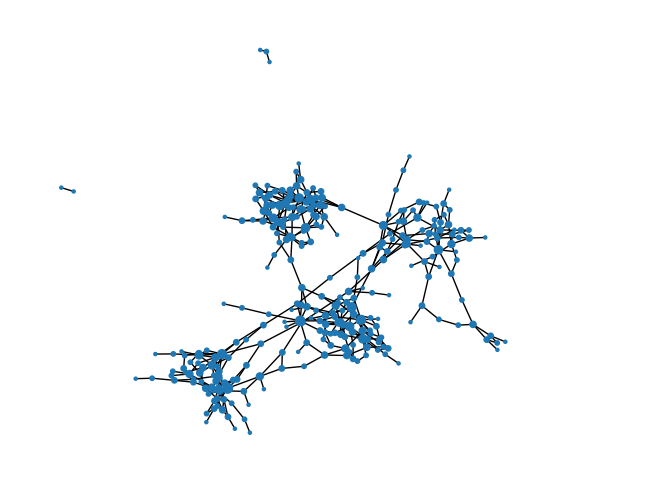

In [4]:
d = dict(G.degree)
nx.draw(G, nodelist=d.keys(), node_size=[v * 5 for v in d.values()])

In [8]:
sim = Simulation(100, G, 5, 100)
sim.run()

In [9]:
print(sim.walker_log)

[[187  69  76 ... 182  17  93]
 [187  69  76 ... 182  17  93]
 [211  69  76 ... 182  17  93]
 ...
 [211   5  87 ...   2  43  93]
 [211  59  87 ...   2  43  93]
 [211  59  87 ...   8  43  93]]


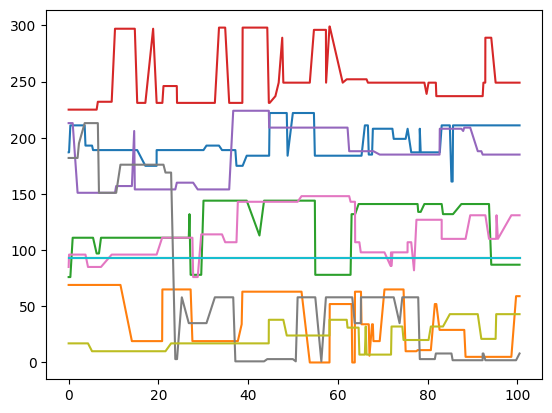

In [10]:
import matplotlib.pyplot as plt

for i in range(sim.n_walkers):
    plt.plot(sim.timeline, sim.walker_log[:,  i])